# Safran Lab 2 


<br>
<div style="text-align: justify">Every day, more than 80,000 commercial flights take place around the world, operated by hundreds of airlines. For all aircraft take-off weight exceeding 27 tons, a regulatory constraint requires companies to systematically record and analyse all flight data, for the purpose of improving the safety of flights. Flight Data Monitoring strives to detect and prioritize deviations from standards set by the aircraft manufacturers, the authorities of civil aviation in the country, or even companies themselves. Such deviations, called events, are used to populate a database that enables companies to identify and monitor the risks inherent to these operations.</div>


<br>

<div style="text-align: justify">This notebook is designed to let you manipulate real aeronautical data, provided by the Safran Group. It is divided in two parts: the first part deals with data exploration, data visualization, the use case, analysis of distributions and simple linear models to predict the fuel consumption of a flight. The second part deals with more complex models, optimization of parameters, interpretation of the results, and models to predict the fuel consumption of each flight phase and finally conclude by the objective of giving pieces of advice to the pilot so that he optimizes the consumption of fuel the next time.</div>

<div class="label label-info">Load the cell below for overall set up</div>

In [2]:
# set up
BASE_DIR = "/mnt/safran/TP2/data/"

import time

import glob

import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.dates as mdates
mpl.rcParams['axes.grid'] = True

import numpy as np
import scipy as sp
import pandas as pd

pd.options.display.max_columns = 23

from datetime import datetime

from sklearn import tree, linear_model, model_selection, preprocessing, decomposition
from sklearn.metrics import mean_squared_error


# read_pickle
dfs = []
files = glob.glob(BASE_DIR + "flights/*.pkl")

p = 0
for idx, file in enumerate(files):
    if idx % int(len(files) / 10) == 0:
        print(str(p * 10) + "%: [" + "#" * p + " " * (10 - p) + "]", end="\r")
        p += 1
    dfs.append(pd.read_pickle(file))


# load global values data, Summarising global values in a dataframe

file_features_df = BASE_DIR + "features_df.pkl"
file_output_df = BASE_DIR + "output_df.pkl"

features_df = pd.read_pickle(file_features_df)
output_df = pd.read_pickle(file_output_df)

# flight_phases

flight_phases = ['APPROACH', 'CLIMB', 'CRUISE', 'DESCENT', 'ENG START', 'FINAL APP',
                 'FLARE', 'INIT CLIMB', 'LANDING', 'TAKE OFF', 'TAXI IN', 'TAXI OUT', 'TOUCH N GO',
                 'LVL CHANGE', 'GO AROUND']

# 1 Know & understand the data 

**Context**

You are provided with nearly 3000 flights operating different routes.

Each flight data is a collection of time series resumed in a dataframe, the sample rate is 1Hz, the columns variables are described in the schema below:


**Schema**

------------
|VAR|DESCRIPTION|UNIT|
|:-----:|:-------:|:---:|
|ORIGIN|Flight departure airport|NA|
|RUNWAY_TO|Flight origin runway|NA|
|DESTINATION|Flight arrival airport|NA|
|RUNWAY_LD|Flight destination runway|NA|
|DATE_HF|High rate date computation|%d/%m/%y (UTC)|
|TIME_HF|High rate time computation|%H:%M:%S (UTC)|
|FLIGHT_PHASE|Current flight-phase|NA|
|ALT_STD_C|Standard altitude corrected|feet|
|HEAD_MAG|Magnetic heading|deg|
|IAS_C|Indicated air speed corrected|knot|
|RALTC|Radio altitude computed from different sources|feet|
|PITCH_C|Pitch attitude corrected|deg|
|ROLL_C|Bank angle corrected|deg|
|FOB|Fuel on board|kg|
|TORQ1_C|Torque corrected (engine 1)|%|
|TORQ2_C|Torque corrected (engine 2)|%|
|NH1_C|NH corrected (engine 1)|%|
|NH2_C|NH corrected (engine 2)|%|
|NL1|NL Left from frequency input|%|
|NL2|NL Right from frequency input (NL2)|%|
|GW_C|Gross weight corrected|kg|

Here are some links to get expertise on some variables:
- [torque](http://www.experimentalaircraft.info/articles/aircraft-engine-performance-1.php)
- [aicraft fuel consumption](https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft#Airline_fuel_efficiency)
- [about FOB and fuel flow](http://www.experimentalaircraft.info/articles/aircraft-engine-instruments-1.php)

## Question 1.1 

- What variables are categorical? 
- What variables are numerical?

In [3]:
features_df.head()

,DATE_HF,ORIGIN,DESTINATION,RUNWAY_TO,RUNWAY_LD,MAX_FOB,MAX_GW,TIME_APPROACH,TIME_CLIMB,TIME_CRUISE,TIME_DESCENT,TIME_ENG START,TIME_FINAL APP,TIME_FLARE,TIME_GO AROUND,TIME_INIT CLIMB,TIME_LANDING,TIME_LVL CHANGE,TIME_TAKE OFF,TIME_TAXI IN,TIME_TAXI OUT,TIME_TOUCH N GO,TIME_TOTAL
0,03/12/15,ARPT0,ARPT1,08,26,2820,20620.0,106,857,1123,762,705,203,12,0,49,36,0,26,222,295,0,4396
1,03/12/15,ARPT0,ARPT1,08,26,2752,18480.0,219,1129,649,933,174,151,7,0,39,53,0,22,219,225,0,3820
2,22/06/15,ARPT0,ARPT3,24,28,2026,17780.0,152,1139,2418,366,354,188,10,0,47,36,323,23,238,215,0,5509
3,10/08/15,ARPT0,ARPT3,08,28,1930,18300.0,32,749,2676,619,249,243,9,0,34,32,0,21,217,182,0,5063
4,21/08/16,ARPT0,ARPT4,20,33,2054,21540.0,62,1038,1040,1210,302,161,5,0,34,24,0,27,506,1016,0,5425


In [18]:
features_df.head()
labels = []
for i in features_df:
    labels.append(i)
print(labels)

['DATE_HF', 'ORIGIN', 'DESTINATION', 'RUNWAY_TO', 'RUNWAY_LD', 'MAX_FOB', 'MAX_GW', 'TIME_APPROACH', 'TIME_CLIMB', 'TIME_CRUISE', 'TIME_DESCENT', 'TIME_ENG START', 'TIME_FINAL APP', 'TIME_FLARE', 'TIME_GO AROUND', 'TIME_INIT CLIMB', 'TIME_LANDING', 'TIME_LVL CHANGE', 'TIME_TAKE OFF', 'TIME_TAXI IN', 'TIME_TAXI OUT', 'TIME_TOUCH N GO', 'TIME_TOTAL']


In [28]:
type(features_df[labels[5]][0])

numpy.int64

In [32]:
# Your code goes here
features_df['DATE_HF'][0]
result = np.zeros(len(flight_phases))
for i in range(len(labels)):
    
    try:
        bla = float(features_df[labels[i]][0])
        result[i] = 1
    except:
        pass
print (result)

[ 0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


** Answer **

As the variable"result "shows, the first 3 feature is categorical, others are numeric

## Visualize all time series for one flight

Let's visualize all the numerical time series for one flight, for example `dfs[0]`, to have a sense of how the time series vary.

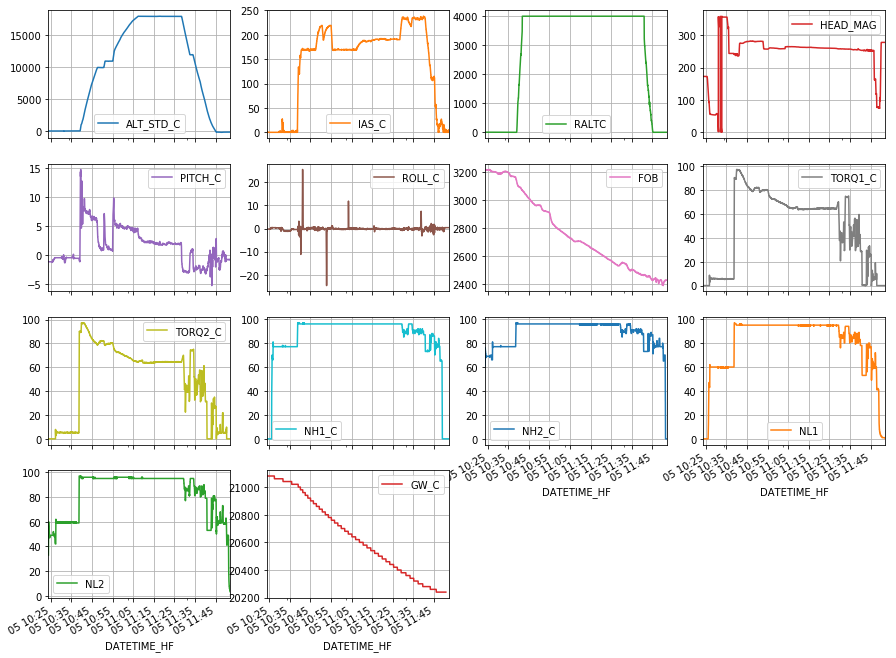

In [33]:
# Give an alias to dfs[0] for convenience
df = dfs[0]

df.plot(kind="line", subplots=True, layout=(4, 4), figsize=(15, 12));

In [40]:
len(df)

5300

## Question 1.2 

Comment this visualization of FOB for several flights. 
- Is there a pattern?
- Do you notice anything strange?

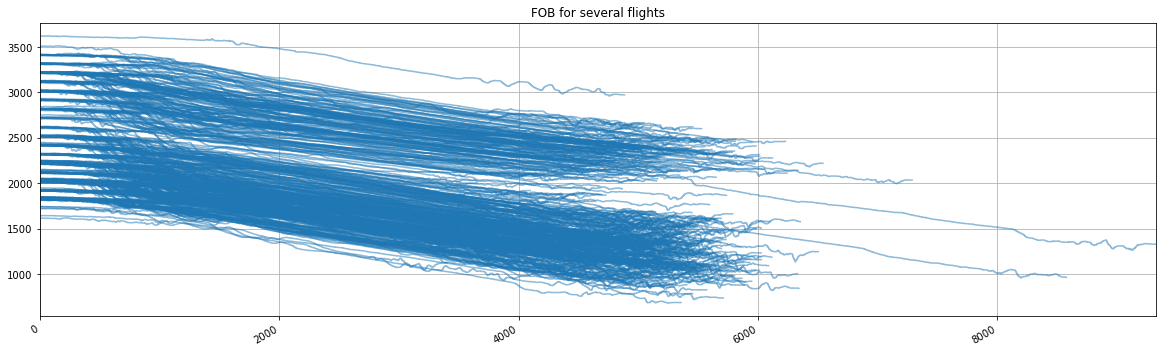

In [41]:
# Create a figure and one subplot
fig, ax = plt.subplots(figsize=(20, 6))

for df in dfs[:500]:
    df.FOB.plot(use_index=False, color="C0", ax=ax, title="FOB for several flights", alpha=0.5)

** Answer **

pattern:
1.in general, the FOB decreases along with the flight phase
2. THe initial FOB is classified to several classes. i.e. the initial Fuel is descrete, not continues.
Strange: The FOB the FOB can fluctuate among the whole process. i.e. the fuel on board may increase somtimes when flight is in the air, which is strange.

## About FLIGHT_PHASE column

Observe how ALT_STD_C varies for each phase

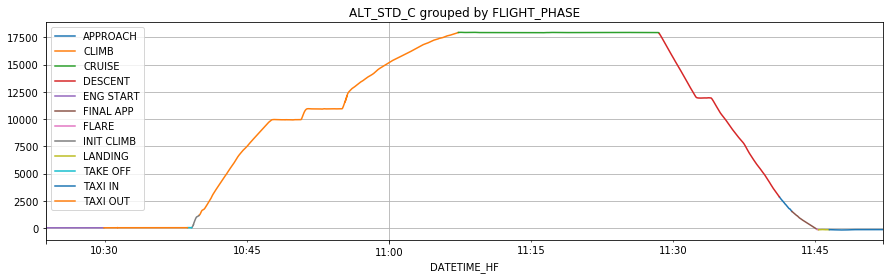

In [42]:
# Create a figure and one subplot
fig, ax = plt.subplots(figsize=(15, 4))

# Give an alias to dfs[0]
df = dfs[0]

df.groupby("FLIGHT_PHASE").ALT_STD_C.plot(title="ALT_STD_C grouped by FLIGHT_PHASE", ax=ax);
ax.legend()

** Typical chronology of cruise phases: **
    - ENG START
    - TAXI OUT
    - TAKE OFF
    - INIT CLIMB
    - CLIMB
    - CRUISE
    - DESCENT
    - APPROACH
    - FINAL APP
    - FLARE
    - LANDING
    - TAXI IN
    
** Phases that exist only for some flights: **
    - LVL CHANGE
    - GO AROUND
    - TOUCH N GO

## About DELTA_FOB

- `MAX_FOB`: FOB at the beginning of the flight
- `MIN_FOB`: FOB at the end of the flight
- `DELTA_FOB`: `MAX_FOB` - `MIN_FOB` the amount of fuel consumed during the whole flight

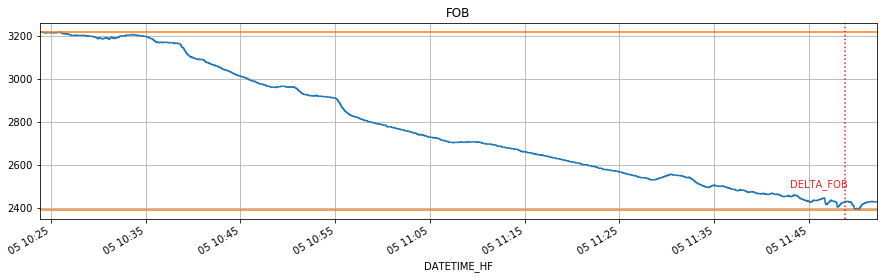

In [43]:
# Create a figure and one subplot
fig, ax = plt.subplots(figsize=(15, 4))

# Give an alias to dfs[0]
df = dfs[0]

df.FOB.plot(title="FOB")
plt.axhline(df.FOB.max(), color="C1")
plt.axhline(df.FOB.min(), color="C1")
plt.axvline(df.FOB.index[-200], linestyle=":", color="C3")
plt.text(df.FOB.index[-550], 2500, "DELTA_FOB", color="C3")

From this FOB signal we will only be interested in deltas, that is the amount of fuel consumed over a certain time period. The first approach will focus on predicting the delta of all the flight, the second approach will be predicting the deltas of each flight phase

# 2 Use case

** The story**

A company asks you to help them optimize the fuel consumption of their fleet. They've been collecting data from their flights for 2 years, operating on four different routes. They do not understand why sometimes the pilots consume 800 kilograms of fuel and sometimes 600 kg for the same route. The company provided you with all their flights. 

Your objective is two-fold:
- Create a model of the quantity of fuel consumed
- Tell the company how their pilots should fly the aircraft to optimize their fuel consumption

In this part we will only use some summarised features of each flight, not the whole time series. Here are the features we will be using:

** features_df ** 

| VAR | DESCRIPTION |
|:--:|:--:|
| DATE_HF | date |
| DESTINATION | destination airport |
| ORIGIN | origin airport |
| RUNWAY_LD | runway landing |
| RUNWAY_TO | runway take-off |
| MAX_FOB | FOB at origin |
| MAX_GW | Gross weigth at origin |
| TIME_APPROACH | Approach length |
| TIME_CLIMB | Climb length |
| TIME_CRUISE | Cruise length |
| TIME_DESCENT | Descent length |
| TIME_ENG START | Eng start length |
| TIME_FINAL APP | Final app length |
| TIME_FLARE | Flare length |
| TIME_GO AROUND | Go around length |
| TIME_INIT CLIMB | Init climb length |
| TIME_LANDING | Landing length |
| TIME_LVL CHANGE | Lvl change length |
| TIME_TAKE OFF | Take off length |
| TIME_TAXI IN | Taxi in length |
| TIME_TAXI OUT | Taxi out length |
| TIME_TOUCH N GO | Touch n go length |
| TIME_TOTAL | Total length |

From these features we want to predict the amount of fuel consumed during the whole flight, that is `DELTA_FOB`. Imagine that at the end of flight the sensor that measures FOB broke and that we cannot know how much fuel we have left.

** output_df **

| VAR | DESCRIPTION |
| :: | :: |
| DELTA_FOB | FOB conso |


The `features_df` containing all the features described above has been computed for you, as well as `output_df`.

In [44]:
features_df = pd.read_pickle(file_features_df)
features_df.head()

,DATE_HF,ORIGIN,DESTINATION,RUNWAY_TO,RUNWAY_LD,MAX_FOB,MAX_GW,TIME_APPROACH,TIME_CLIMB,TIME_CRUISE,TIME_DESCENT,TIME_ENG START,TIME_FINAL APP,TIME_FLARE,TIME_GO AROUND,TIME_INIT CLIMB,TIME_LANDING,TIME_LVL CHANGE,TIME_TAKE OFF,TIME_TAXI IN,TIME_TAXI OUT,TIME_TOUCH N GO,TIME_TOTAL
0,03/12/15,ARPT0,ARPT1,08,26,2820,20620.0,106,857,1123,762,705,203,12,0,49,36,0,26,222,295,0,4396
1,03/12/15,ARPT0,ARPT1,08,26,2752,18480.0,219,1129,649,933,174,151,7,0,39,53,0,22,219,225,0,3820
2,22/06/15,ARPT0,ARPT3,24,28,2026,17780.0,152,1139,2418,366,354,188,10,0,47,36,323,23,238,215,0,5509
3,10/08/15,ARPT0,ARPT3,08,28,1930,18300.0,32,749,2676,619,249,243,9,0,34,32,0,21,217,182,0,5063
4,21/08/16,ARPT0,ARPT4,20,33,2054,21540.0,62,1038,1040,1210,302,161,5,0,34,24,0,27,506,1016,0,5425


In [45]:
output_df = pd.read_pickle(file_output_df)
output_df.head()

,DELTA_FOB
0,668
1,630
2,1072
3,1000
4,926


## Question 2.1

In this question we compute some statistics about the population of flights:
- How many different origin airports? 
- How many different destination airports?
- How many routes? How many flights per route?

In [73]:
# Your code goes here
#origin airport
n1 = len(features_df['ORIGIN'].unique())
n2 = len(features_df['DESTINATION'].unique())
print("No. of original airports:",n1)
#dest airport
print("No. of dest airports:",n2)
print("No. of routes:",n1*n2)\

for i in range(4):
    print(features_df.groupby("DESTINATION").count().iloc[i][0])


    

No. of original airports: 1
No. of dest airports: 4
No. of routes: 4
415
956
929
442


** Answer **

1.No. of original airports: 1  
2.No. of dest airports: 4  
3.No. of routes: 4  
No. of flight per route: 
415  
956  
929  
442

## Question 2.2

In this question we focus on the output we want to predict: `DELTA_FOB` in dataframe `output_df`

- Plot the DELTA_FOB distribution and comment. 
- What influences the most DELTA_FOB according to you? There is no right or wrong answer.

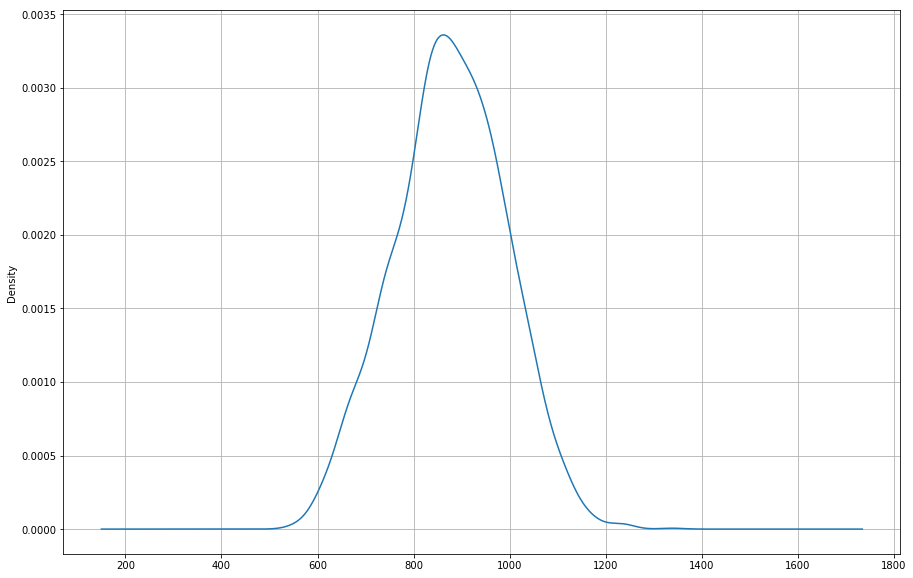

In [8]:
# Your code goes here
output_df['DELTA_FOB'].plot(figsize = (15,10),kind = 'kde')


** Answer **

According to the figure, the DELTA_FOB has the general value range from 600 to 1200.
THe most frequent DELTA_FOB among all the flights is between [800,1000]
We think the key factor than influencing the DELTA_FOB is the distance and the flying time. THe longer the distance, the more time you take, the flight will consume a higher delta FOB

## Question 2.2

In this question we work on the distributions of `DELTA_FOB` conditionned on `DESTINATION` and (optional) `RUNWAY_LD`

- Plot `DELTA_FOB` distribution conditionned on `DESTINATION` airport and comment.
- (optional) Plot `DELTA_FOB` distribution conditionned on `DESTINATION` airport and `RUNWAY_LD` and comment.

In [12]:
# Your code goes here
'''
join the two table
'''
result = features_df.join(output_df,how = 'inner')
result.head()

,DATE_HF,ORIGIN,DESTINATION,RUNWAY_TO,RUNWAY_LD,MAX_FOB,MAX_GW,TIME_APPROACH,TIME_CLIMB,TIME_CRUISE,TIME_DESCENT,...,TIME_FLARE,TIME_GO AROUND,TIME_INIT CLIMB,TIME_LANDING,TIME_LVL CHANGE,TIME_TAKE OFF,TIME_TAXI IN,TIME_TAXI OUT,TIME_TOUCH N GO,TIME_TOTAL,DELTA_FOB
0,03/12/15,ARPT0,ARPT1,08,26,2820,20620.0,106,857,1123,762,...,12,0,49,36,0,26,222,295,0,4396,668
1,03/12/15,ARPT0,ARPT1,08,26,2752,18480.0,219,1129,649,933,...,7,0,39,53,0,22,219,225,0,3820,630
2,22/06/15,ARPT0,ARPT3,24,28,2026,17780.0,152,1139,2418,366,...,10,0,47,36,323,23,238,215,0,5509,1072
3,10/08/15,ARPT0,ARPT3,08,28,1930,18300.0,32,749,2676,619,...,9,0,34,32,0,21,217,182,0,5063,1000
4,21/08/16,ARPT0,ARPT4,20,33,2054,21540.0,62,1038,1040,1210,...,5,0,34,24,0,27,506,1016,0,5425,926


DESTINATION
ARPT1    Axes(0.125,0.125;0.775x0.755)
ARPT2    Axes(0.125,0.125;0.775x0.755)
ARPT3    Axes(0.125,0.125;0.775x0.755)
ARPT4    Axes(0.125,0.125;0.775x0.755)
Name: DELTA_FOB, dtype: object

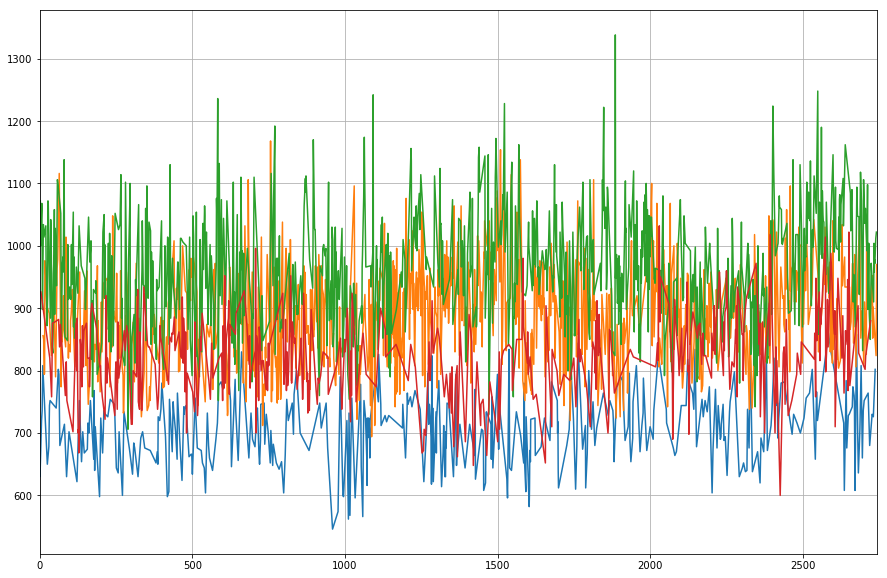

In [26]:
result.groupby('DESTINATION').DELTA_FOB.plot(figsize = (15,10))

** Answer **

THe result shows that different destination airport has a clearly different value of DELTA_FOB. The flight heading to the same destination has the same DELTA_FOB

## Question 2.3

Finally let's work with two important features: the total duration of the flight `TOTAL_TIME` and the quantity of fuel at the beginning of the flight `MAX_FOB`.
- Plot the distributions of the following variables:
     - `MAX_FOB`
     - `TIME_TOTAL`
- Comment these distributions

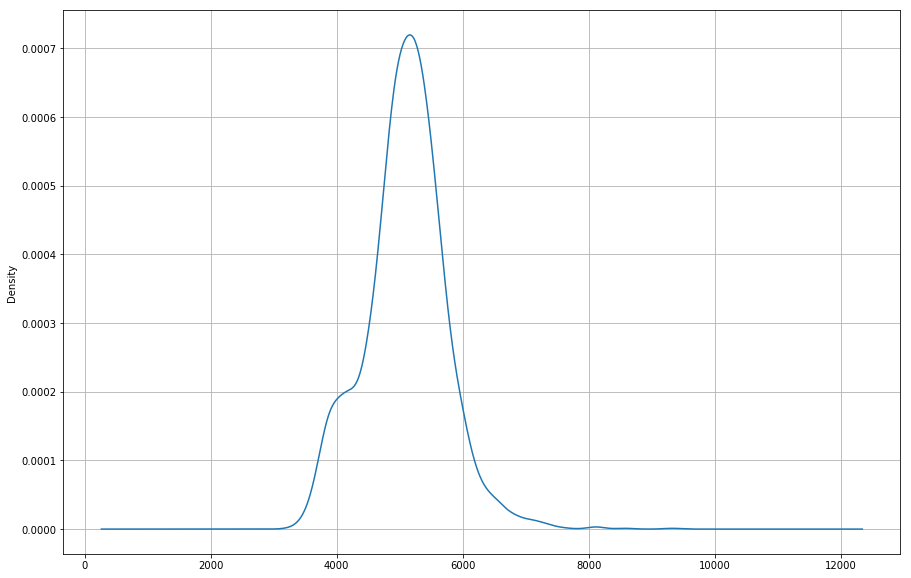

In [35]:
# Your code goes here
features_df['TIME_TOTAL'].plot(figsize = (15,10),kind = 'kde')


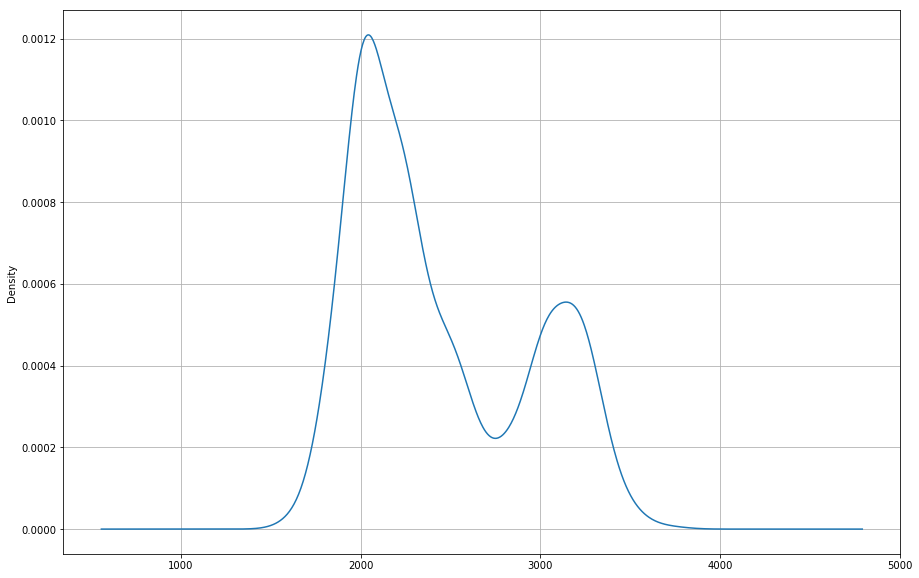

In [37]:
features_df['MAX_FOB'].plot(figsize = (15,10),kind = 'kde')

** Answer **
Most of the flights experience the flying time ranging from [4000,6000];
And there are 2 comman value of MAX_FOB: 2000 and 3000

# 3 Model DELTA_FOB

We use [sklearn](http://scikit-learn.org/stable/documentation.html) for models.

## Question 3.1

- Scatter plot `TIME_TOTAL` against `DELTA_FOB`.
- Is there any relationship?

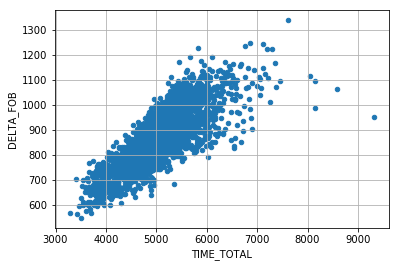

In [42]:
# Your code goes here

result.plot.scatter(x= 'TIME_TOTAL',y = 'DELTA_FOB')

** Answer **

THe scatter figure above shows there is a rough linear relationship between DELTA-FOB and TIME_TOTAL

Let's explore the predictive power of `TIME_TOTAL` on `DELTA_FOB`. Our first model is the following linear regression:
- algorithm: `LinearRegression` from sklearn package `linear_model` ([reference](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html))
- input: `TIME_TOTAL`
- output: `DELTA_FOB`

Follow the code below, in the following questions you will extensively use this template code and adapt it.

## Question 3.2

Comment briefly the results, the following questions can help you:
- What is the score method implemented by sklearn?
- How do you relate it to the mse?
- What is best to interprete the quality of the estimator?

In [43]:
# This is template code for setting up a sklearn regression model

X = features_df[["TIME_TOTAL"]].as_matrix()

y = output_df[["DELTA_FOB"]].as_matrix()

test_size = 0.2
random_state = 42

# Split the features and output in training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)

# Create linear regression object
estimator = linear_model.LinearRegression()

# Train the model using the training sets
estimator.fit(X_train, y_train)

# Test the model on tests sets
print("score", estimator.score(X_test, y_test))

score 0.606144364551


** Answer **
The score method returns the coefficient of determination R^2 of the prediction.    
The coefficient R^2 is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred)^2).sum()  and v is the residual sum of squares ((y_true - y_true.mean()) ^2).sum().  
While $$MSE = ((y\_true - y\_pred)^2).sum()/N$$

## Question 3.3

- Adapt the code above for the following model
    - algorithm: `LinearRegression` 
    - input: `TIME_TOTAL`, `MAX_FOB`
    - output: `DELTA_FOB`

- Compare the score with the results of the previous regression
    - is it getting better?
    - which variable has the most predictive power among `TIME_TOTAL` and `MAX_FOB`?

In [97]:
# Your code goes here
# This is template code for setting up a sklearn regression model

X_33 = features_df[["TIME_TOTAL", "MAX_FOB"]].as_matrix()
X_2 = features_df[["MAX_FOB"]].as_matrix()
# X_33 = np.hstack((X1,X2))


y = output_df[["DELTA_FOB"]].as_matrix()

test_size = 0.2
random_state = 42

# Split the features and output in training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_33, y, test_size=test_size, random_state=random_state)

# Create linear regression object
estimator = linear_model.LinearRegression()

# Train the model using the training sets
estimator.fit(X_train, y_train)

# Test the model on tests sets
print("score", estimator.score(X_test, y_test))

score 0.708710764451


In [98]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_2, y, test_size=test_size, random_state=random_state)

# Create linear regression object
estimator = linear_model.LinearRegression()

# Train the model using the training sets
estimator.fit(X_train, y_train)

# Test the model on tests sets
print("score", estimator.score(X_test, y_test))

score 0.0797671623189


** Answer **

The result(score) is better then the single input.
As computed above, the 'TIME_TOTAL' is more predictive to the DELTA_FOB because the score is higer than MAX-FOB


Before moving on and adding more features to our models, let's compare our linear regressions to a simple non-linear model:
- algorithm: `DecisionTreeRegressor` from sklearn package `tree` ([reference](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html))
- input: `TIME_TOTAL`, `MAX_FOB`
- output: `DELTA_FOB`

## Question 3.4

- Adapt the code for the model described above.

- What is the default behavior for `max_depth` parameter?
- With a default behavior, is the score better than with linear regression?
- Split in 10 validation sets and optimize `max_depth` parameter (you can use the template code below)
    - plot `max_depth` parameters against the score
    - why is it not OK to optimize parameters only with train and test sets?
- What attributes can you use to you interprete the tree?

In [132]:
'''
default maxdepth
'''
estimator =  tree.DecisionTreeRegressor()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_33, y, test_size=test_size, random_state=random_state)
estimator.fit(X_train, y_train)
score = estimator.score(X_test, y_test)
print(score)

0.588388532083


** Answer **
- With a default behavior, the score is 0.0109289617486, which worse than linear regression

- With only train and test data, the model is easily to get overfitting, so we need cross validation to modifier the model. Also, after applying cross validation, we can use every data bunch to train and tune the model, so the data set more efficiently used.

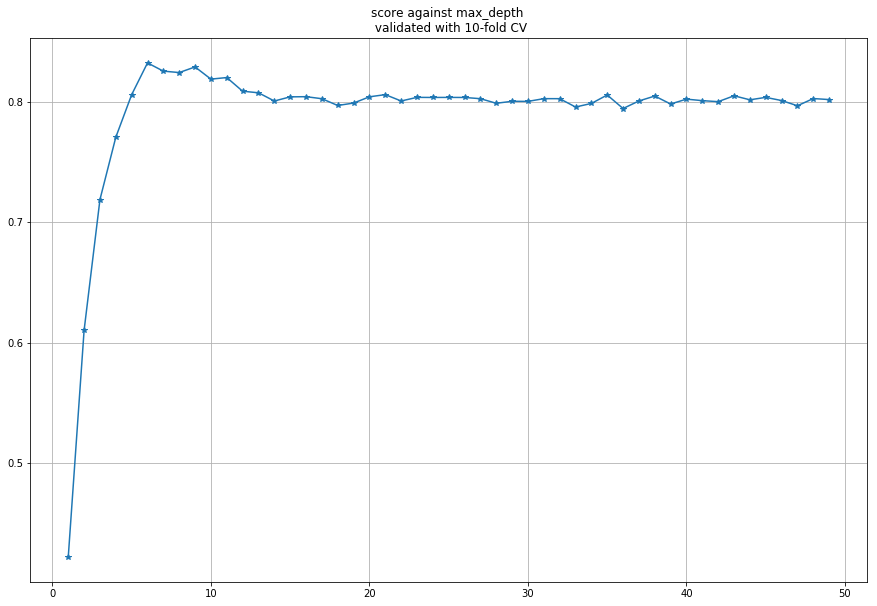

In [134]:
# This is the template code for cross validation, fill in the blanks

max_depths = range(1,50)

kFold = model_selection.KFold(n_splits=10)
scores = []

for max_depth in max_depths:
    estimator.set_params(max_depth=max_depth)
    score = []
    folds = kFold.split(X_33)
    for fold in folds:
        # Unpack train and test indices
        train, test = fold
        # Split in train and test sets 
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        estimator.fit(X_train, y_train)
        score.append(estimator.score(X_test, y_test))
    scores.append(np.mean(score))
plt.figure(figsize = (15,10))
plt.plot(max_depths,scores, marker="*")
plt.title("score against max_depth \n validated with 10-fold CV")


** Answer **

According to the result, the best depth of the tree is `6`. After around `14`, the model converges to local minmum and has no improvement.

Let's add all the other numeric features.

In [77]:
numeric_features = ['MAX_FOB',
                    'MAX_GW',
                    'TIME_APPROACH',
                    'TIME_CLIMB',
                    'TIME_CRUISE',
                    'TIME_DESCENT',
                    'TIME_ENG START',
                    'TIME_FINAL APP',
                    'TIME_FLARE',
                    'TIME_GO AROUND',
                    'TIME_INIT CLIMB',
                    'TIME_LANDING',
                    'TIME_LVL CHANGE',
                    'TIME_TAKE OFF',
                    'TIME_TAXI IN',
                    'TIME_TAXI OUT',
                    'TIME_TOUCH N GO',
                    'TIME_TOTAL']

## Question 3.5

In Question 3.5 we will use regularized regression.
In this question we take a preliminary step and rescale the features.

We use the `StandardScaler` from sklearn `preprocessing` package ([reference](http://scikit-learn.org/stable/modules/preprocessing.html)).

- Give one reason for rescaling the features before doing regularized regression
- Fill in the blanks in the code below and observe the results printed out
- Why the first feature of `X_test_transformed` does not have a std of 1?

In [84]:
# This is the template code for rescaling the features, fill in the blanks
X = features_df[numeric_features].as_matrix()

y = output_df[["DELTA_FOB"]].as_matrix()

test_size = 0.2
random_state = 42
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)


scaler = preprocessing.StandardScaler()

scaler.fit(X_train) # Fill in the blanks

X_train_transformed = scaler.transform(X_train) # Fill in the blanks
X_test_transformed = scaler.transform(X_test) # Fill in the blanks

print("X_train_transformed first feature,", "mean:", X_train_transformed[:, 0].mean(), "std:", X_train_transformed[:, 0].std()) 
print("X_test_transformed first feature,", "mean:", X_test_transformed[:, 0].mean(), "std:", X_test_transformed[:, 0].std())

X_train_transformed first feature, mean: -1.36892068335e-16 std: 1.0
X_test_transformed first feature, mean: 0.0510960710978 std: 1.03838428734


** Answer **

- Because different feature has different range of numerical value, so in order to avoid some feature has strong impact on the result while other feature with low numerical value has no contributio on the model, we should rescale eache value of feature to ensure their value to be in the similar, comparable range.  
- Why the first feature of X_test_transformed does not have a std 1?  
Because the scaler.fit() funcion is used on X_train, so when we implement the scalar.transform, the `X_train` will have std = 1 but X_test won't

The last question of this part focus on regularized linear regression.
- algorithm: `Ridge` for sklearn package `linear_model` ([reference](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html))
- input: `numeric_features` of `features_df`
- output: `DELTA_FOB`

## Question 3.6

- Use the previous template codes and adapt it to set up the models described above and rescale the features

- Split in validation sets and optimize `alpha` parameter
- Interprete the coefficients of your best estimator

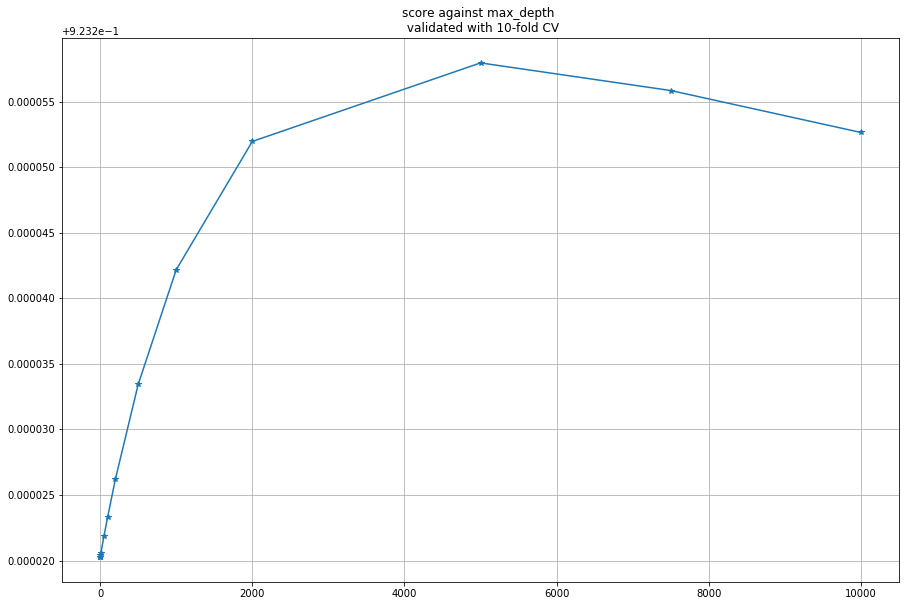

In [135]:
# This is the template code for cross validation, fill in the blanks
estimator = linear_model.Ridge()
# alphas = np.array(range(20))/10
# alphas = alphas.tolist()
alphas = [0.1,0.5,1,5,10,50,100,200,500,1000,2000,5000,7500,10000]

kFold = model_selection.KFold(n_splits=10)
scores = []
for alpha in alphas:
    estimator.set_params(alpha = alpha)
    score = []
    folds = kFold.split(X)
    for fold in folds:
        # Unpack train and test indices
        train, test = fold
        # Split in train and test sets 
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        estimator.fit(X_train, y_train)
        score.append(estimator.score(X_test, y_test))
    scores.append(np.mean(score))
plt.figure(figsize = (15,10))
plt.plot(alphas,scores, marker="*")
plt.title("score against max_depth \n validated with 10-fold CV")


In [139]:
estimator.coef_[0]

array([-0.08888783,  0.00600624,  0.09832672,  0.04966331,  0.09802506,
        0.11027636, -0.07504029,  0.03718645, -0.24265935,  0.05536181,
        0.17781385, -0.33446976,  0.17986239,  0.05173224, -0.07871405,
       -0.01964498,  0.        ,  0.10771976])

** Answer **

THe graph above shows that the score of Ridge Regression is quite low, and changing alpha doesn't make an evident improvement on the score. Therefore, Ridge Regression is not a suitable method on this dataset, linear regression is a better choice.

# 4 Feature engineering & model delta_fob for each phase 

We will add a lot of information with engine-related time series:
- `TORQ1_C`, `TORQ2_C`
- `NL1`, `NL2`
- `NH1_C`, `NH2_C`

## Visualization of engine-related time series for one flight

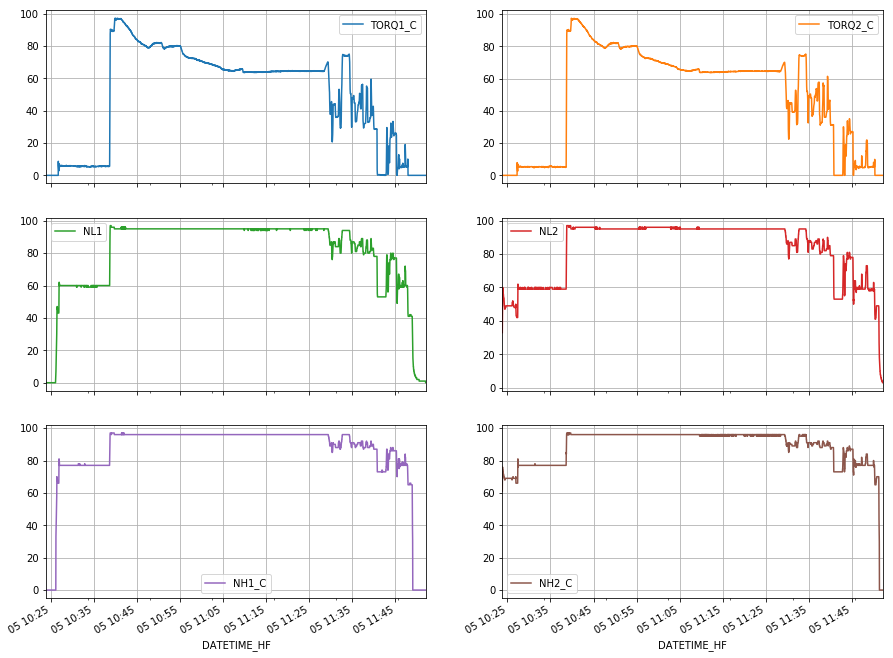

In [140]:
# Five an alias to dfs[0]
df = dfs[0]

engine_features = ['TORQ1_C', 'TORQ2_C',
                  'NL1', 'NL2',
                  'NH1_C', 'NH2_C']

df[engine_features].plot(subplots=True, layout=(3, 2), figsize=(15, 12));

## Question 4.1

We will extract few numbers out of each phase for all engine variables (`TORQ1_C`, `TORQ2_C`, `NL1`, `NL2`, `NH1_C`, `NH2_C`)

- Feature engineering
    - get `TORQ1_C` of one phase of one flight, do a linear regression by index and plot the result
    - is it OK to resume the signal by a straight line? what other features would you add?

In [175]:
# Your code goes here
df_c = df[['FLIGHT_PHASE','TORQ1_C']].as_matrix()
df_cc = []
for i in df_c:
    
    if i[0] == 'CLIMB':
        df_cc.append(i)
df_cc = np.array(df_cc)
print(df_cc)

[['CLIMB' 96.9]
 ['CLIMB' 96.9]
 ['CLIMB' 97.2]
 ..., 
 ['CLIMB' 64.5]
 ['CLIMB' 64.4]
 ['CLIMB' 64.4]]


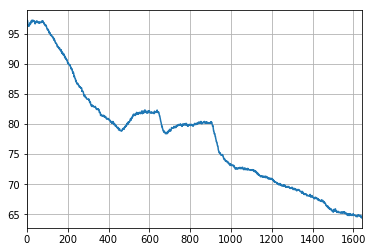

In [180]:
df_ccc = pd.DataFrame(data = df_cc)
df_ccc[1].plot()

** Answer **

It's basically distributed linearly, but a little bit fluctuate

These features have been created for you in the `features2_df` dataframe.

## Recap features2_df

In [181]:
file_features2 = BASE_DIR + "features2_df.pkl"

features2_df = pd.read_pickle(file_features2)

numeric_features2 = list(features2_df.columns.values)
numeric_features2.remove("DATE_HF")
numeric_features2.remove("ORIGIN")
numeric_features2.remove("DESTINATION")
numeric_features2.remove("RUNWAY_TO")
numeric_features2.remove("RUNWAY_LD")

features2_df.describe()

,MAX_FOB,MAX_GW,TIME_APPROACH,TIME_CLIMB,TIME_CRUISE,TIME_DESCENT,TIME_ENG START,TIME_FINAL APP,TIME_FLARE,TIME_GO AROUND,TIME_INIT CLIMB,...,GO AROUND_NL2_sum,GO AROUND_NH1_C_intercept,GO AROUND_NH1_C_slope,GO AROUND_NH1_C_mean,GO AROUND_NH1_C_median,GO AROUND_NH1_C_sum,GO AROUND_NH2_C_intercept,GO AROUND_NH2_C_slope,GO AROUND_NH2_C_mean,GO AROUND_NH2_C_median,GO AROUND_NH2_C_sum
count,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,...,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000,2742.000000
mean,2439.663020,20495.557987,143.109044,1190.589351,1568.312181,745.985412,496.062728,193.513494,8.628009,3.467177,48.092268,...,293.386214,0.620627,-0.000196,0.592350,0.592633,312.923414,0.617573,-0.000199,0.588722,0.589351,310.746900
std,482.857964,1161.616565,94.942888,258.253887,581.133001,182.289871,307.850561,78.275612,2.584759,54.190701,11.540036,...,4601.951816,7.637718,0.003073,7.289696,7.294202,4909.082612,7.600159,0.003068,7.244929,7.253416,4868.284591
min,1616.000000,17300.000000,1.000000,85.000000,9.000000,230.000000,127.000000,65.000000,1.000000,0.000000,17.000000,...,0.000000,0.000000,-0.092567,0.000000,0.000000,0.000000,0.000000,-0.089114,0.000000,0.000000,0.000000
25%,2028.000000,19640.000000,83.000000,1012.000000,1102.250000,613.000000,322.000000,143.000000,7.000000,0.000000,40.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2243.000000,20540.000000,126.000000,1160.000000,1687.500000,715.000000,411.000000,174.000000,8.000000,0.000000,47.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2922.000000,21400.000000,187.000000,1340.000000,1995.750000,854.000000,566.000000,216.000000,10.000000,0.000000,54.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3732.000000,23440.000000,1560.000000,2445.000000,3467.000000,1892.000000,5142.000000,748.000000,24.000000,1715.000000,133.000000,...,147688.000000,98.646564,0.000000,94.434783,97.000000,156919.000000,97.793829,0.000000,93.739130,96.000000,154950.000000


Let's be more ambitious and predict the fuel consumed by each phase. It would help a lot more to model the fuel consumption behavior for each phase when it will come to interpretation. The dataframe `output2_df` containing the fuel consumed by each phase for each flight has been created for you.

In [207]:
file_output2 = BASE_DIR + "output2_df.pkl"
output2_df = pd.read_pickle(file_output2)

output2_df.head()

,APPROACH,CLIMB,CRUISE,DESCENT,ENG START,FINAL APP,FLARE,GO AROUND,INIT CLIMB,LANDING,LVL CHANGE,TAKE OFF,TAXI IN,TAXI OUT,TOUCH N GO
0,12.0,186.0,180.0,112.0,22.0,12.0,6.0,0.0,60.0,20.0,0.0,40.0,26.0,32.0,0.0
1,28.0,218.0,88.0,146.0,12.0,20.0,2.0,0.0,42.0,16.0,0.0,42.0,20.0,38.0,0.0
2,66.0,256.0,532.0,112.0,18.0,38.0,8.0,0.0,18.0,76.0,178.0,30.0,64.0,22.0,0.0
3,20.0,138.0,552.0,186.0,16.0,54.0,4.0,0.0,28.0,64.0,0.0,22.0,36.0,20.0,0.0
4,44.0,192.0,230.0,240.0,16.0,42.0,4.0,0.0,30.0,82.0,0.0,22.0,94.0,90.0,0.0


## Question 4.3

In this question we make use of `output2_df` to determine the phase that consumes the most fuel per second in average.

- What flight phase consumes the most in average?
- What flight phase consumes the most per second in average?

In [183]:
# This is template code to extract the phases durations out of features_df and rename the columns to make them identical to output2_df

phases_durations_df = features2_df[["TIME_" + fp for fp in flight_phases]]
phases_durations_df.columns = flight_phases
phases_durations_df.head()

,APPROACH,CLIMB,CRUISE,DESCENT,ENG START,FINAL APP,FLARE,INIT CLIMB,LANDING,TAKE OFF,TAXI IN,TAXI OUT,TOUCH N GO,LVL CHANGE,GO AROUND
0,106,857,1123,762,705,203,12,49,36,26,222,295,0,0,0
1,219,1129,649,933,174,151,7,39,53,22,219,225,0,0,0
2,152,1139,2418,366,354,188,10,47,36,23,238,215,0,323,0
3,32,749,2676,619,249,243,9,34,32,21,217,182,0,0,0
4,62,1038,1040,1210,302,161,5,34,24,27,506,1016,0,0,0


In [206]:
# Your code goes here
'''
What flight phase consumes the most in average?
'''
desc = output2_df.describe()
means = []
for fp in flight_phases:
    means.append(desc[fp]['mean'])
idx = means.index(np.max(means))
result = flight_phases[idx]
print("%s phase consumes the most in average"%result)

CRUISE phase consumes the most in average


** Answer **

CRUISE phase consumes the most in average

## Question 4.4

This last question aims to let you work with `features2_df` and `output2_df`. You can make use of any pieces of code we have worked with so far: especially to set up your models, rescale the features, optimize and validate your models...  The expected outcome is to explain to the company what parameters influence the most the fuel consumption of their fleet and give them advice to consume less.

- The algorithm:
    - algorithm: you choose
    - input: `features2_df`, output: `output2_df`
    
- Interprete the coefficients, explain the causes of fuel consumption for each phase, give adive to the company to consume less in their following flights

In [3]:
# Your code goes here

** Answer **

Your answer goes here